## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)

cv2.destroyAllWindows()

## And so on and so forth calculating calibration matrix and distortion coefficients

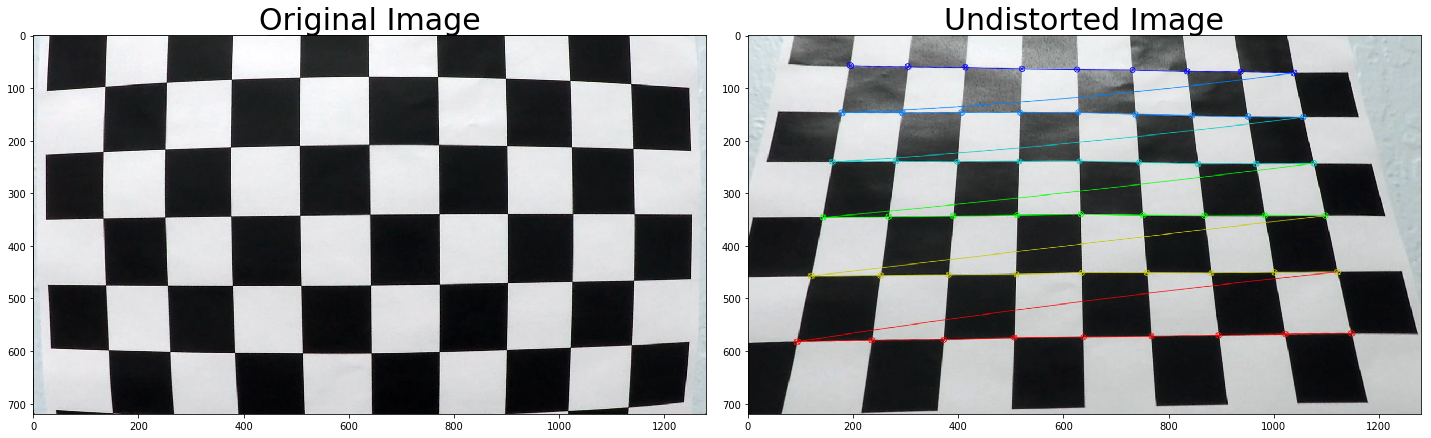

In [2]:
import pickle
%matplotlib inline

# Import first image and use as a test.
name_img_test = '../camera_cal/calibration1.jpg'
img_test = cv2.imread(name_img_test)
img_size = (img_test.shape[1], img_test.shape[0])

# Given object points and image point, I'll do camera calibration and undistort
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Plotting orginal and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Correction of one test image

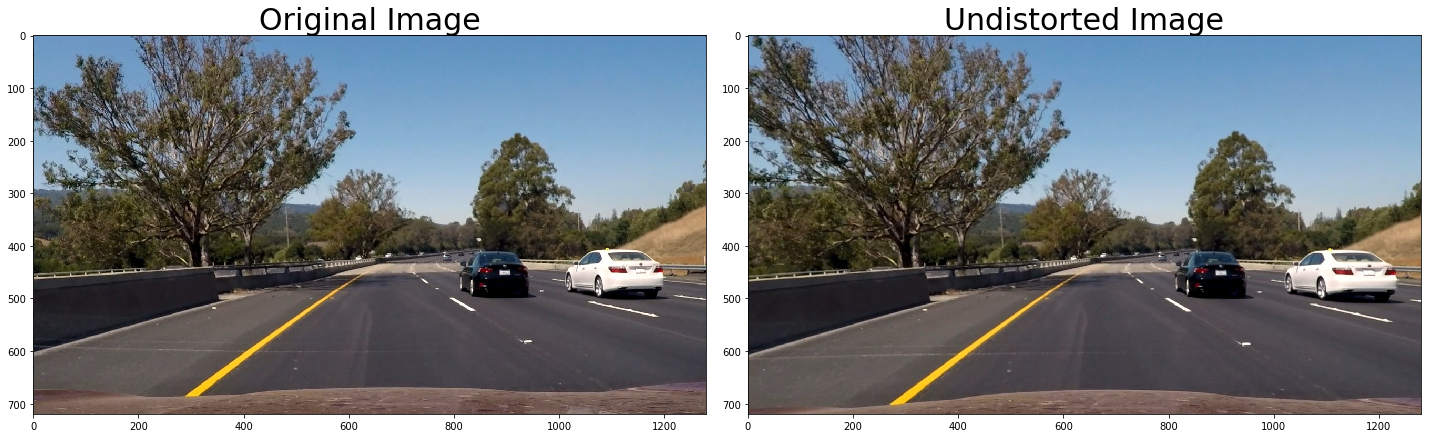

In [3]:
# Import test image
image = cv2.imread('../test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_size = (img_test.shape[1], img_test.shape[0])

# Undistort test image
undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)

# Plotting orginal and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

In [97]:
# Sobel Threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

# Magnitude Threshold
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    sobel = np.power(sobelx,2) + np.power(sobely,2)
    sobel = np.sqrt(sobel)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

# Direction Threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# Threshold by channel S of HLS
def s_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return sxbinary
    
def final_threshold(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sx_binary = abs_sobel_thresh(img, 'x', thresh=(20, 200))
    dir_binary = dir_threshold(img, thresh=(0.7, 1.3))
    
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # Color Channel Threshold - RGB
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    
    combined = np.zeros_like(gray)
    condition_rg = (R > color_threshold) & (G > color_threshold)
    
    # Color Channel Thresholds - HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel works well for brightness yellow and white lanes
    thresh_s = (100, 255)
    condition_s = (S > thresh_s[0]) & (S <= thresh_s[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    thresh_l = (120, 255)
    condition_l = (L > thresh_l[0]) & (L <= thresh_l[1])

    # Combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    combined[(condition_rg & condition_l) & (condition_s | combined_condition)] = 1
    
    return combined

def final_threshold_2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    combined = np.zeros_like(gray)
    
    
    # Color Channel Threshold - Luv
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L = luv[:,:,0]
    thresh_l = (100,150)
    condition_l = (L > thresh_l[0]) & (L <= thresh_l[1])
    
    # Color Channel Threshold - Lab
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    B = lab[:,:,2]
    thresh_b = (100,150)
    condition_b = (B > thresh_b[0]) & (B <= thresh_b[1])
    
    combined[(condition_b)] = 1
    return combined


In [5]:
ksize = 3

gradx = abs_sobel_thresh(undistorted_image, orient='x', sobel_kernel=ksize, thresh=(20,100))
grady = abs_sobel_thresh(undistorted_image, orient='y', sobel_kernel=ksize, thresh=(20,100))
mag_binary = mag_thresh(undistorted_image, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(undistorted_image, sobel_kernel=15, thresh=(0.7, 1.3))
s_binary = s_threshold(undistorted_image)
image_binary = pipeline(undistorted_image)

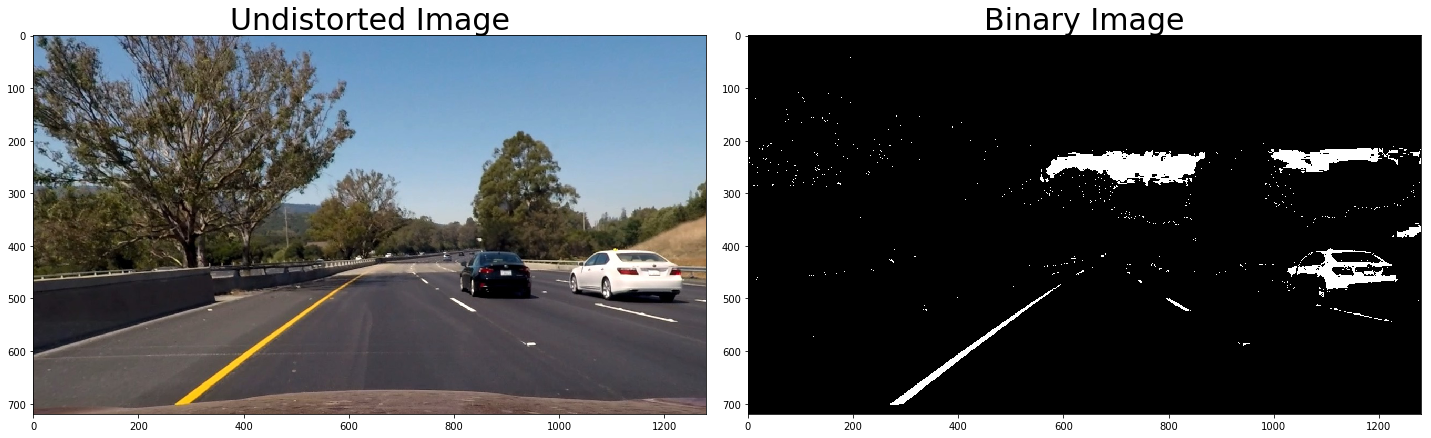

In [6]:
# Plotting orginal and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(undistorted_image)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(image_binary,cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

## Applying Perspective and Borders

In [7]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

In [8]:
src = np.float32(
    [[578,460],
    [190,720],
    [1127,720],
    [707,460]])
dst = np.float32(
    [[320, 0],
    [320, 720],
    [960, 720],
    [960, 0]])

In [9]:
# Limits of Area of Interest
def margen(img, corners):
    eps = 1e-5
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    region_select = np.copy(img)

    left_top = corners[0]
    left_bottom = corners[1]
    right_bottom = corners[2]
    right_top = corners[3]

    pts = np.array([left_top,left_bottom,right_bottom,right_top], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    return copy

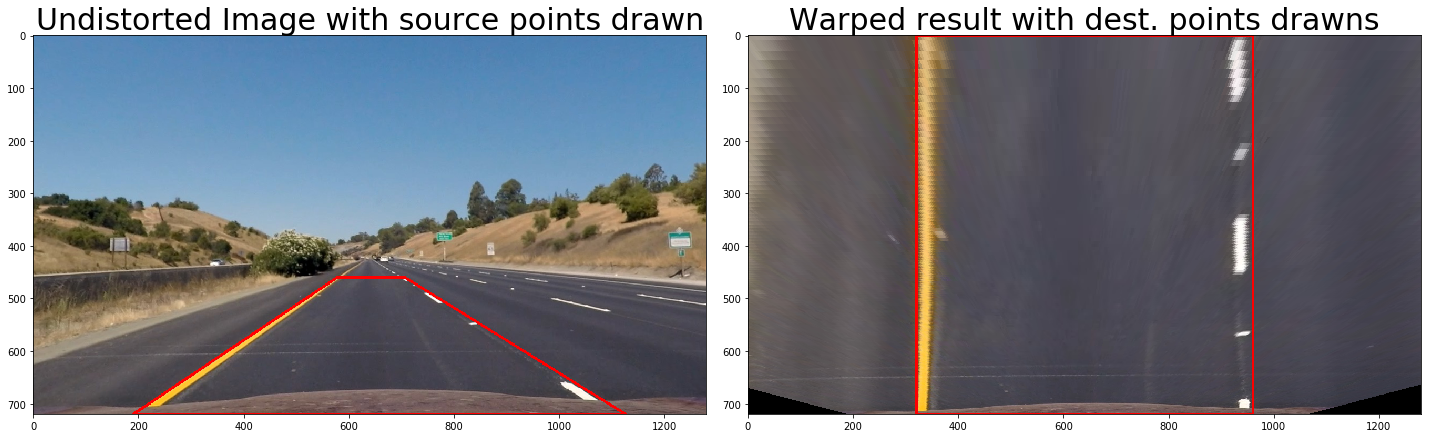

In [10]:
image2 = cv2.imread('../test_images/straight_lines1.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

undistorted_image = cv2.undistort(image2, mtx, dist, None, mtx)
warped_image = warper(undistorted_image, src, dst)

margened_image = margen(undistorted_image, src)
margened_warped_image = margen(warped_image, dst)

# Plotting orginal and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(margened_image)
ax1.set_title('Undistorted Image with source points drawn', fontsize=30)
ax2.imshow(margened_warped_image)
ax2.set_title('Warped result with dest. points drawns', fontsize=30)

## Thresholds to the perspectives

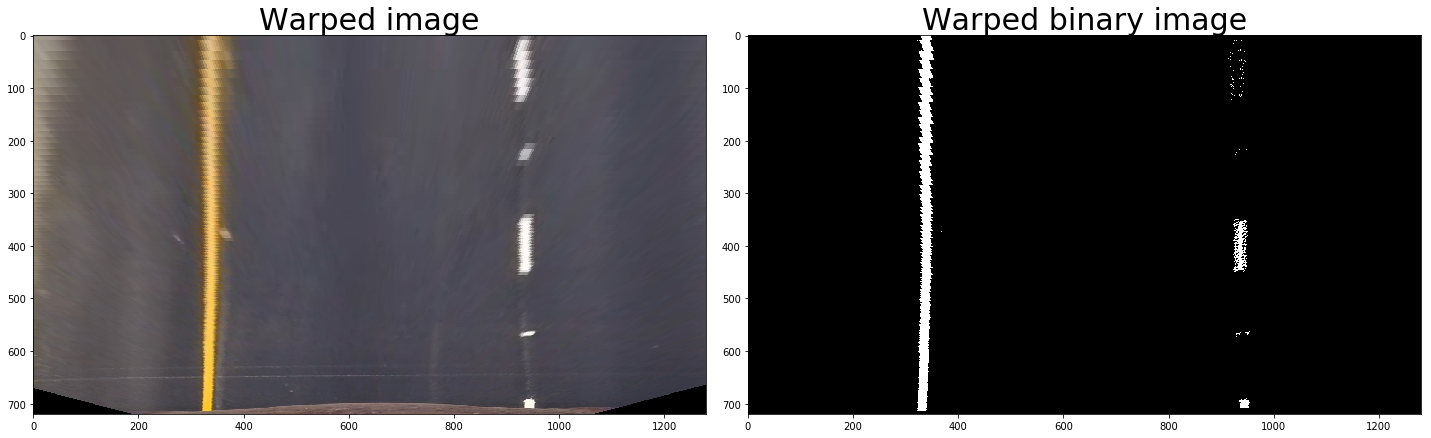

In [11]:
ksize = 3

gradx = abs_sobel_thresh(warped_image, orient='x', sobel_kernel=ksize, thresh=(20,100))
grady = abs_sobel_thresh(warped_image, orient='y', sobel_kernel=ksize, thresh=(20,100))
mag_binary = mag_thresh(warped_image, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(warped_image, sobel_kernel=15, thresh=(0.7, 1.3))
s_binary = s_threshold(warped_image)
image_binary = pipeline(warped_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(warped_image)
ax1.set_title('Warped image', fontsize=30)
ax2.imshow(image_binary, cmap='gray')
ax2.set_title('Warped binary image', fontsize=30)

## Histogram

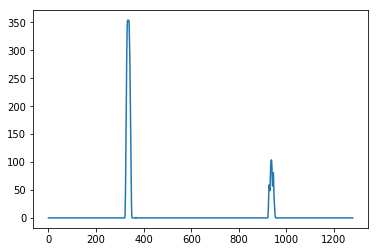

In [12]:
import numpy as np
img = image_binary
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Sliding Window Search

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = image_binary
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

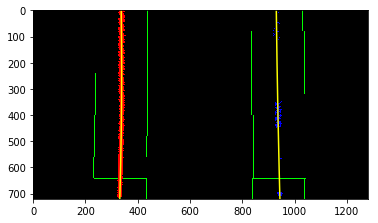

In [14]:
# Visualization

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Searching around a previously detected line

In [15]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

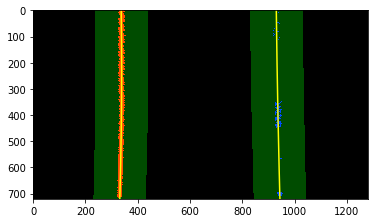

In [16]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measuring Curvature

In [17]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

16488.5163147 49149.3729165


In [18]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

5408.80426776 m 16126.6920865 m


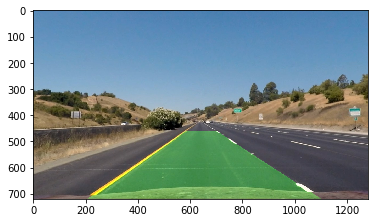

In [19]:
warp_zero = np.zeros_like(image_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Calculating Inverse matrix of perspective
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

def final_pipeline(img):

    img_size = (img.shape[1], img.shape[0])
    
    # Undistort test image
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Warp images
    warped_image = warper(undistorted_image, src, dst)
    
    # Applying thresholds
    image_binary = final_threshold(warped_image)

    histogram = np.sum(image_binary[image_binary.shape[0]//2:,:], axis=0)
    
    binary_warped = image_binary
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    ## Visualization of Window search

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    # Calculating Curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    warp_zero = np.zeros_like(image_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Calculating Inverse matrix of perspective
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    # Calculate Offset
    dir_ = ""
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    aux = img_size[0]/2 - lane_center
    if aux > 0:
        dir_ = "right"
    else:
        dir_ = "left"
    center_offset_pixels = abs(aux) # Distance of center
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    
    curv = "Radius of curvature: %.2f m" % ((left_curverad + right_curverad) / 2.0)
    offset = "Center offset: %.2f m %s of center" % (center_offset_mtrs, dir_)
    
    cv2.putText(result, curv , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result


In [80]:
def pipeline_2(img):
    
    img_copy = np.copy(img)
    
    img_size = (img.shape[1], img.shape[0])
    
    # Undistort test image
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Warp images
    warped_image = warper(undistorted_image, src, dst)
    
    # Applying thresholds
    image_binary = final_threshold(warped_image)
    
    x_offset = 400
    y_offset = 250
    s_img = cv2.resize(image_binary, (x_offset, y_offset))
    s_img = np.dstack((s_img, s_img, s_img))*255

    img_copy[ 10:y_offset+10,(img_size[0]-10-x_offset):-10] = s_img
    
    return img_copy

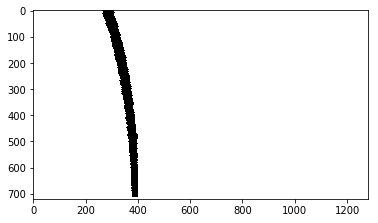

In [119]:
def final_threshold_2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    combined = np.zeros_like(gray)
    
    
    # Color Channel Threshold - Luv
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L = luv[:,:,0]
    thresh_l = (100,150)
    condition_l = (L > thresh_l[0]) & (L <= thresh_l[1])
    
    # Color Channel Threshold - Lab
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    B = lab[:,:,2]
    thresh_b = (100,150)
    condition_b = (B > thresh_b[0]) & (B <= thresh_b[1])
    
    combined[condition_b] = 1
    #combined[condition_l] = 1
    #combined[(condition_b==0) & (condition_l==1)] = 1

    return combined



img = cv2.imread('../test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
img_size = (img.shape[1], img.shape[0])

# Undistort test image
undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)

# Warp images
warped_image = warper(undistorted_image, src, dst)

# Applying thresholds
image_binary = final_threshold_2(warped_image)

s_img = np.dstack((image_binary, image_binary, image_binary))*255
plt.imshow(s_img,cmap="gray")
plt.show()
    

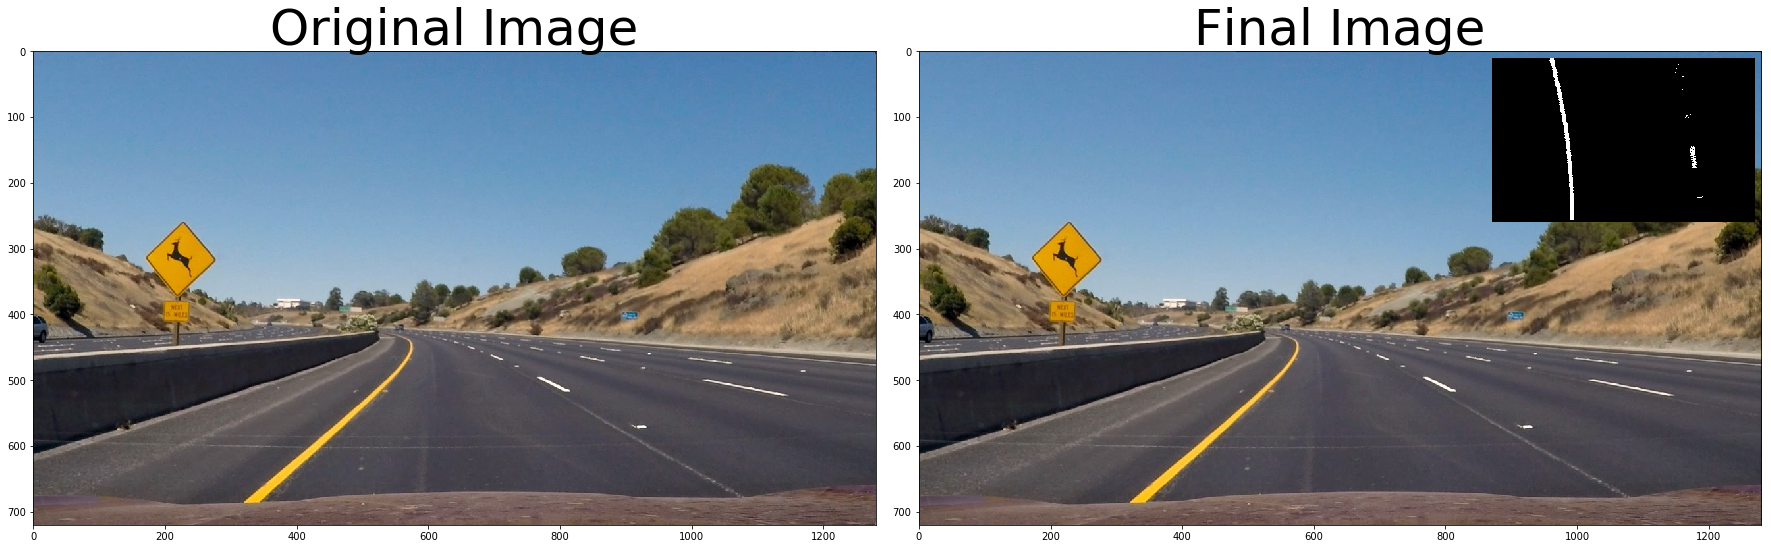

In [86]:
img = cv2.imread('../test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

final_image = pipeline_2(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(final_image, cmap='gray')
ax2.set_title('Final Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline Video

In [78]:
from moviepy.editor import VideoFileClip

In [83]:
output = 'project_video_output_2.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline_2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_2.mp4
[MoviePy] Writing video project_video_output_2.mp4


100%|█████████▉| 1260/1261 [04:59<00:00,  4.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_2.mp4 

CPU times: user 6min 33s, sys: 3.11 s, total: 6min 36s
Wall time: 5min 1s


In [84]:
output = 'project_challenge_video_output.mp4'
clip1 = VideoFileClip("../challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_challenge_video_output.mp4
[MoviePy] Writing video project_challenge_video_output.mp4


100%|██████████| 485/485 [01:48<00:00,  4.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_challenge_video_output.mp4 

CPU times: user 2min 23s, sys: 1.27 s, total: 2min 25s
Wall time: 1min 50s


In [134]:
output = 'salida.mp4'
clip1 = VideoFileClip("../challenge_video.mp4").subclip(0,4)
white_clip = clip1.fl_image(final_pipeline)

In [135]:
white_clip.write_videofile(output,audio=False)

[MoviePy] >>>> Building video salida.mp4
[MoviePy] Writing video salida.mp4



100%|██████████| 120/120 [00:31<00:00,  3.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: salida.mp4 

